# Patch Extraction from Mammograms

The following code provides the tools for extracting patches from the [BCDR dataset](https://bcdr.eu/information/about). Given the path where this dataset is saved, the code outputs the following:

- A folder named 'healthy_patch_dataset' containing healthy patches extracted from film and digital mammograms.
- A folder named 'lesion_patch_dataset' containing patches of lesions extracted from film and digital mammograms using manually annotated masks. These patches are extracted at different levels of zoom, with varying percentages of healthy adjacent tissue included. There are three different levels of zoom available. Zoom group 1 corresponds to the minimum percentage of healthy adjacent tissue, i.e. to a bounding box of the annotated lesion.
- 'digital_healthy_patch_features.csv': a CSV file containing the features of the healthy patches extracted from digital mammograms.
- 'film_healthy_patch_features.csv': a CSV file containing the features of the healthy patches extracted from film mammograms.
- 'lesion_patch_features.csv': a CSV file containing the features of the lesion patches.

In the BCDR dataset, only normal (healthy) mammograms are available in the digital dataset. To extract healthy patches from film mammograms as well, I extracted patches from healthy tissue in suspicious film images. I ensured that there was a margin between the extracted healthy patches and the lesion patch.

Note:
- All generated images are 224x224 pixels, black and white, and in PNG format.
- Each generated patch has a unique ID that corresponds to the metadata saved in the respective CSV file.


In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import os
import skimage.io as skio
import pandas as pd
import re

In [3]:
root=input("Path of BCDR folder: ")
# C:\Users\marta\Documents\MASTER_UB\TFM\datasets\BDCR

In order to extract the lesion patches, I have used the corresponding mask annotations. Here is a sample image along with its corresponding mask:

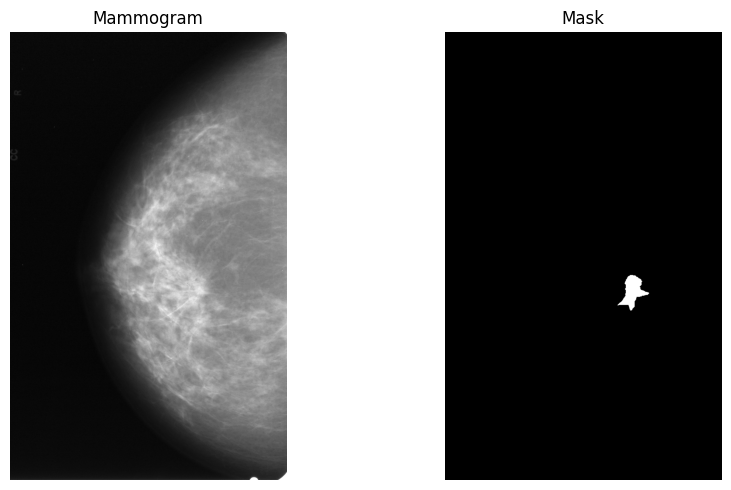

In [10]:
example_image_path= os.path.join(root, "BCDR-F01_dataset\patient_9\study_10\img_9_10_1_RCC.tif")
example_mask_path= os.path.join(root, "BCDR-F01_dataset\patient_9\study_10\img_9_10_1_RCC_mask_id_10.tif")

img1 = skio.imread(example_image_path, plugin="tifffile")
img1_mask = skio.imread(example_mask_path, plugin="tifffile")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img1, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Mammogram')

axes[1].imshow(img1_mask, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Mask')

plt.tight_layout()
plt.show()

For a digital sample:

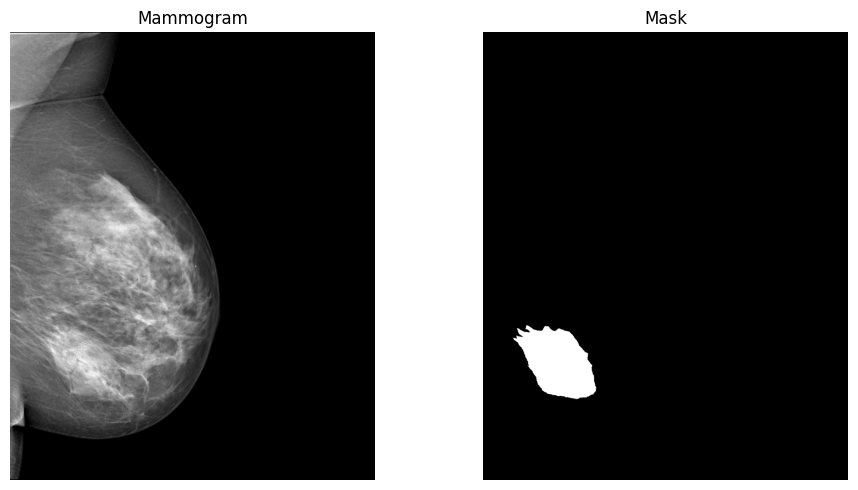

In [4]:
example_image_path= os.path.join(root, "BCDR-D02_dataset\patient_139\study_188\img_139_188_1_LO.tif")
example_mask_path= os.path.join(root, "BCDR-D02_dataset\patient_139\study_188\img_139_188_1_LO_mask_id_228.tif")

img1 = skio.imread(example_image_path, plugin="tifffile")
img1_mask = skio.imread(example_mask_path, plugin="tifffile")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img1, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Mammogram')

axes[1].imshow(img1_mask, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Mask')

plt.tight_layout()
plt.show()

Applying a threshold to the mammogram and joining it with the mask:

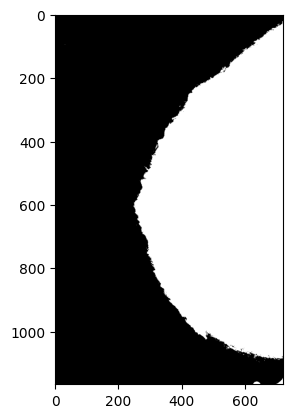

In [11]:
#Apply thresholding to the image
ret, thresh = cv.threshold(img1, 1, 255, cv.THRESH_OTSU)
#find the contours in the image
contours, heirarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
plt.imshow(thresh, cmap='gray')
plt.show()

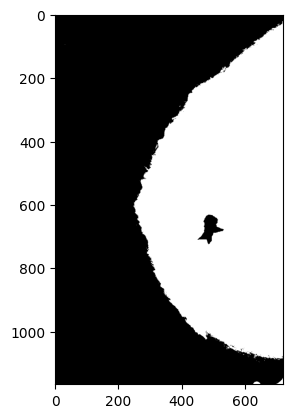

In [12]:
img1_mask_inverted=cv.bitwise_not(img1_mask)
dst = cv.addWeighted(thresh, 0.5, img1_mask_inverted, 0.5, 0.0)
plt.imshow(dst, cmap='gray')
plt.show()

Some utils to create the folders and to save the patches with an unique id as file name.

In [13]:
def create_patch_dataset(rootpath, healthy=False):
    '''It creates a folder for healthy patches and lesion patches.'''
    if healthy:
        path=os.path.join(rootpath, r'data\\healthy_patch_dataset')
    else:
        path=os.path.join(rootpath, r'data\\lesion_patch_dataset')
    if not os.path.exists(path):
        os.makedirs(path)
        
    return path

def save_patch(folder, patch, file_name, extension, patch_id):
    '''It saves the patch in the corresponding folder with the corresponding patch ID. '''
    #save the image in the folder 
    os.chdir(folder)
    cv.imwrite(str(patch_id)+'.png', patch)
    print('\n patch saved as '+ str(patch_id)+'.png')


The following functions are utility functions for extracting the patches:

- 'check_intersection': Given two rectangles, it checks if they intersect. This function is used to extract the healthy patches from the film mammograms.

- 'white_pixels': Given a thresholded patch, it returns 'True' if the number of white pixels exceeds the specified 'ratio_white'. This function is used to avoid patches with a higher ratio of background pixels than desired.

- 'sliding_window': it yields a window of the mammogram covering the full image.

- 'gif_healthy_patch_extractor'. This function takes as input: 
    - an image (matrix)
    - the width and height of the window to be extracted (they will be resized to 221x221)
    - the percentage of the width to be the step size of the sliding windows process
    - the maximum ratio of white pixels for the 'white_pixels' function
	- the mask (matrix) of the lesion, if it is a suspicious image, otherwise, it is None
    
    The output is a sequence of images with the patch contours to visualise how the algorithm works.

- 'healthy_patch_extractor': It does the same procedure as 'gif_healthy_patch_extractor' function, but it saves the patches in the corresponding folder.

In [14]:
def check_intersection(rect1, rect2):
    # rect1 and rect2 are tuples of (x, y, width, height)
	#It returns True if they overlap and False if they don't
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    # Calculate the coordinates of the corners of the two rectangles
    x1_right, y1_bottom = x1 + w1, y1 + h1
    x2_right, y2_bottom = x2 + w2, y2 + h2

    # Check if there is any overlap between the two rectangles
    if x1_right >= x2 and x2_right >= x1 and y1_bottom >= y2 and y2_bottom >= y1:
        return True
    else:
        return False
    
def white_pixels(ratio_white, patch):
    #Returns true if more than 'ratio_white' pixels are white
    #ratio_white is for example 0.5 for checking a 50%
    width, height = patch.shape
    white_pixels = 0
    for x in range(width):
        for y in range(height):
            pixel = patch[x, y]
            if pixel == 255:
                white_pixels += 1

    # Check if more than X of the pixels are white
    total_pixels = width * height
    if white_pixels / total_pixels >= ratio_white:
        return True
    else:
        return False


In [15]:
import time 

def sliding_window(image, stepSize, windowSize):
	#stepSize=1 i.e. sliding windows pixel by pixel
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

def gif_healthy_patch_extractor(image, w, h, step_size_per, white_pix_per, mask=None, suspicious=False):
	'''
		image: matrix
		w, h: width and height of the window, they will be resized to 221x221
		step_size_per: percentage of the width to be the step size of the sliding windows process
		white_pix_per: minimum percentage of the patch to correspond to mamma and not to background 
		mask: matrix, only for the suspicious one, for non suspicious it is None
	'''
	#Apply thresholding to the image
	ret, thresh = cv.threshold(image, 1, 255, cv.THRESH_OTSU)
	
	if suspicious:
		img1_mask_inverted=cv.bitwise_not(mask)
		dst = cv.addWeighted(thresh, 0.5, img1_mask_inverted, 0.5, 0.0)   
	else:
		dst=thresh

	#Step size based on the percentage passed to the function
	step_size= int(step_size_per*w)
	for (x, y, window) in sliding_window(dst, step_size, (w,h)):
		if window.shape[0] != w or window.shape[1] != h:
				continue
		
		if suspicious:
			#We get the lesion coordinates and its width and height
			x_lesion, y_lesion, width_lesion, height_lesion=cv.boundingRect(mask) 

			#We check that any of the coordinates included in 'window' are not inside the lesion patch + A MARGIN (from (x_lesion,y_lesion) to (x_lesion+width_lesion,y_lesion+height_lesion))
			#Window coordinates: from (x, y) to (x+221, y+221)
			if check_intersection((x_lesion, y_lesion, width_lesion, height_lesion),(x, y, w, h))== True:
				continue
		
		if white_pixels(white_pix_per, window)==True:
			#save image
			# Create a Rectangle patch
			img_box = cv.rectangle(image, (x,y),(x+w,y+h), (255, 0, 0) , 3)
			plt.imshow(img_box, cmap='gray')
			plt.show()
			time.sleep(0.25)
		else: 
			#too many pixels from the background
			continue


def healthy_patch_extractor(dataset, patch_path,  patch_id, image, zoom_group, w, h, step_size_per, white_pix_per, file_name, mask=None, suspicious=False):
	'''
		patch_id: next patch identifier
		image: matrix
		w, h: width and height of the window, they will be resized to 221x221
		step_size_per: percentage of the width to be the step size of the sliding windows process
		white_pix_per: minimum percentage of the patch to correspond to mamma and not to background 
		file_name: name of the mammogram in order to save the patch with it
		mask: matrix, only for the suspicious one, for non suspicious it is None
	'''

	ret, thresh = cv.threshold(image, 1, 255, cv.THRESH_OTSU)

	if suspicious:
		img1_mask_inverted=cv.bitwise_not(mask)
		dst = cv.addWeighted(thresh, 0.5, img1_mask_inverted, 0.5, 0.0)
	else:
		dst=thresh
  
	step_size= int(step_size_per*w)

	for (x, y, window) in sliding_window(dst, step_size, (w,h)):
		if window.shape[0] != w or window.shape[1] != h:
				continue
		if zoom_group==1:
			w=w
			h=h
		if suspicious:
			#We get the lesion coordinates and its width and height
			x_lesion, y_lesion, width_lesion, height_lesion=cv.boundingRect(mask) 

			#WE ADD A MARGIN TO THIS RECTANGLE
			x_lesion=x_lesion-0.1*w
			y_lesion=y_lesion-0.1*w
			width_lesion=width_lesion+2*0.1*w
			height_lesion=height_lesion+2*0.1*w

			#We check that any of the coordinates included in 'window' are not inside the lesion patch + A MARGIN (from (x_lesion,y_lesion) to (x_lesion+width_lesion,y_lesion+height_lesion))
			#Window coordinates: from (x, y) to (x+221, y+221)
			if check_intersection((x_lesion, y_lesion, width_lesion, height_lesion),(x, y, w, h))== True:
				continue
			
		if white_pixels(white_pix_per, window)==True:
			patch=image[y:y+h, x:x+w]
			patch=cv.resize(patch, (224,224))
			#Save it:
			save_patch(patch_path, patch, file_name, dataset, patch_id)
			patch_id=patch_id+1
		else: 
			continue
	return patch_id

Running the 'gif' function for suspicious mammograms to visualise the patches extracted from a suspicious film image.

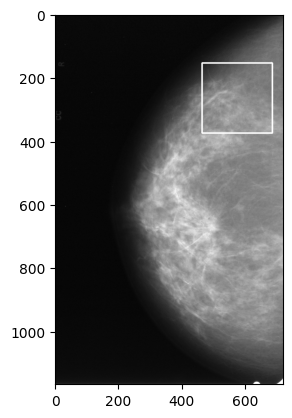

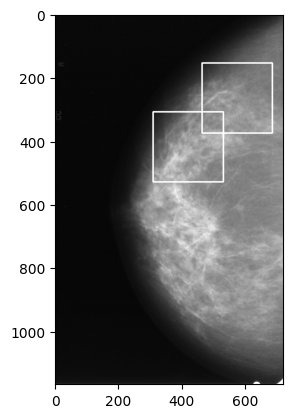

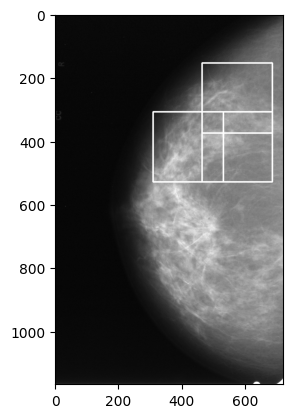

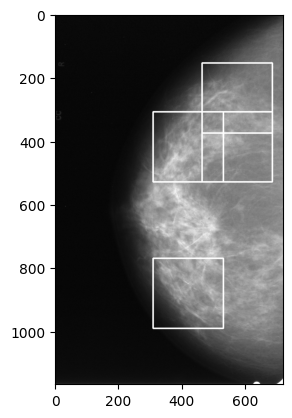

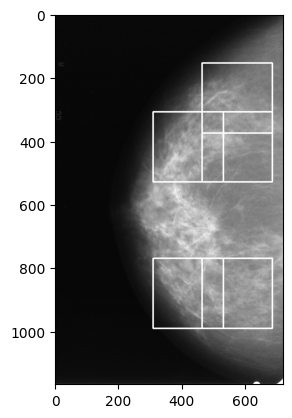

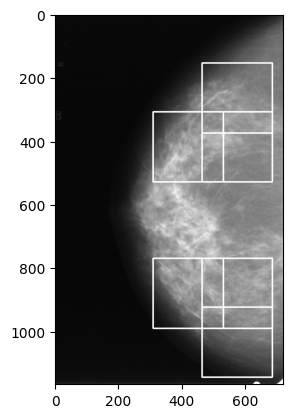

In [16]:
#Demo of how the healthy patch extractor works for a suspicious mammo
path=os.path.join(root, 'BCDR-F01_dataset\patient_9\study_10\img_9_10_1_RCC.tif')
img1 = skio.imread(path, plugin="tifffile")
mask_path=os.path.join(root, 'BCDR-F01_dataset\patient_9\study_10\img_9_10_1_RCC_mask_id_10.tif')
img1_mask = skio.imread(mask_path, plugin="tifffile")

step_per=0.7
white_per=0.5
gif_healthy_patch_extractor(img1, 221, 221, step_per, white_per, img1_mask, suspicious=True)

Running the 'gif' function for a non suspicious mammogram to visualise the patches extracted from a normal digital image.

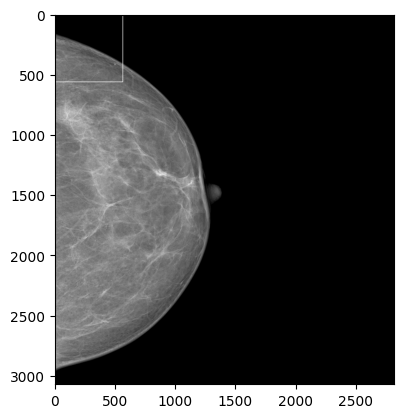

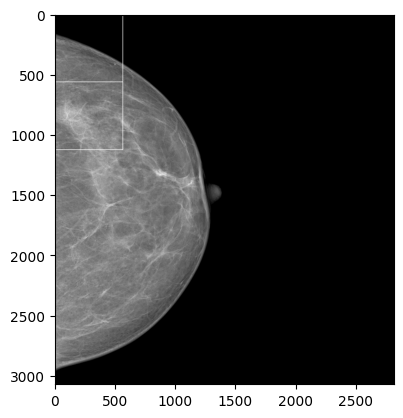

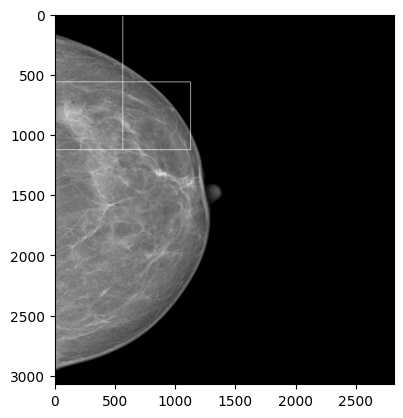

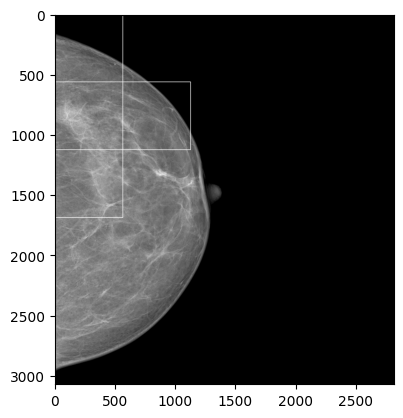

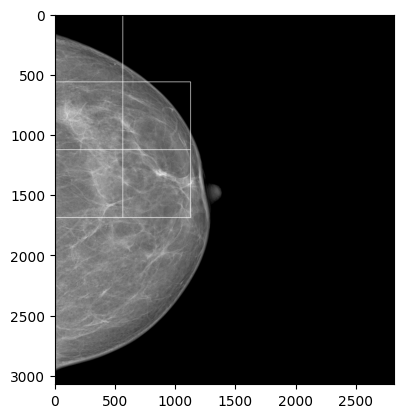

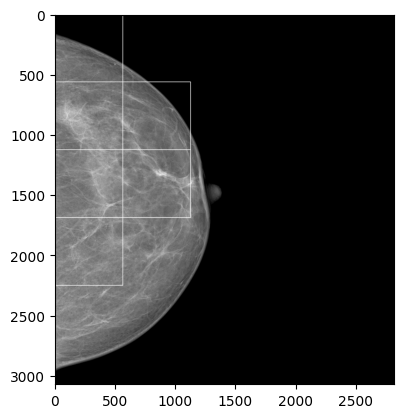

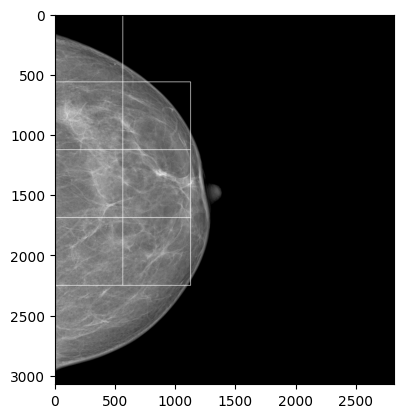

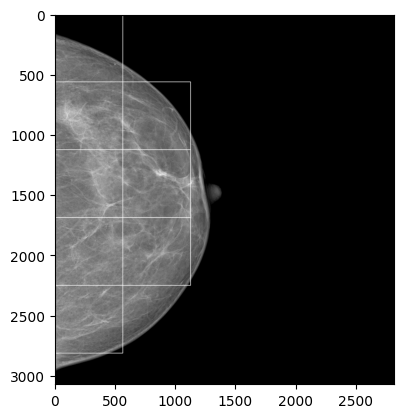

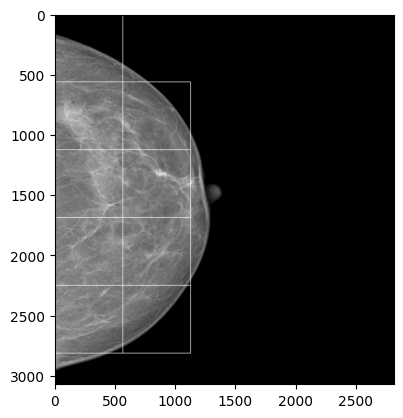

In [17]:
path=os.path.join(root, 'BCDR-DN01_dataset\patient_23\study_33\img_23_33_1_LCC.tif')
img2 = skio.imread(path, plugin="tifffile")
w=h=int(img2.shape[1]*0.2)
step_size_per=1
white_per=0.5


gif_healthy_patch_extractor(img2, w, h, step_size_per, white_per)


# Extracting patches sistematically

Some utilities:
- 'image_view_from_file': from the image view label, create an integer mapping
- 'img_id': given the original mammography file name, it returns the patient id, the study id, the series and the image view
- 'non_suspicious_patch_extraction': Patch extraction from NON suspicious digital mammograms.

In [5]:
#Type of image view (1-RCC, 2-LCC, 3-RO, 4-LO)
def image_view_from_file(s):
    if (s.find("RCC")>0): return 1
    elif (s.find("LCC")>0): return 2
    elif (s.find("RO")>0): return 3
    elif (s.find("LO")>0): return 4
    else: return 0

#Retrieve information from the mammography file name 
def img_id(s):
    patient_id, study_id, series=re.findall(r'\d+', s)
    image_view=image_view_from_file(s)
    return patient_id, study_id, series, image_view

In [6]:
def non_suspicious_patch_extraction(patch_id):
    '''
        Patch extraction from NON suspicious digital mammograms
    '''
    healthy_patch_path=create_patch_dataset(root,healthy=True)

    ext='BCDR-DN01_dataset'
    rootdir=os.path.join(root, ext)

    print('Working on ', ext, ' subdataset.')

    # Read the corresponding .csv file
    df= pd.DataFrame()
    df_path=r'C:\\Users\\marta\\Documents\\MASTER UB\\TFM\\datasets\\BDCR\\BCDR-DN01_dataset\\bcdr_dn01_img.csv'
    df = pd.read_csv(df_path)
        
    #Name of the subdataset
    dataset= ext.partition("_dataset")[0]
    dataset=dataset.partition("-")[2]  

    #Create an empty patch_dataset file to save the info related to every patch
    digital_healthy_patch=pd.DataFrame(columns = df.columns)

    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if file.endswith(".tif"):
                file_mammo=file.partition(".tif")[0] 
                
                patient_id, study_id, series, image_view=img_id(file_mammo) #retrieve info of the image from the file name

                file_path=os.path.join(rootdir, 'patient_'+ patient_id, 'study_'+ study_id, file) #directory of the mammo
                mammo = skio.imread(file_path, plugin="tifffile") #read the mammo

                w=h=int(mammo.shape[1]*0.2)
                step_size_per=1.0
                white_per=0.6
                zoom=1

                #The function returns the patch_id of the following one (the first one extracted from the following image)
                patch_id_new=healthy_patch_extractor(dataset, healthy_patch_path, patch_id, mammo,zoom, w, h, step_size_per, white_per, file_mammo)

                n_patches=patch_id_new-patch_id

                '''Save healthy patches metadata'''

                patch_data=pd.DataFrame()

                patch_data=df.loc[(df['patient_id'] == int(patient_id)) & (df['study_id'] == int(study_id)) & (df['series'] == int(series)) & (df['image_type_id']== int(image_view-1))]
                if patch_data.shape[0]>1:
                    patch_data=patch_data.head(1)

                #print(patch_data)
                row_to_copy=patch_data.iloc[0].tolist()       
                #del row_to_copy[0] 
                copies = [row_to_copy] * n_patches
                copies=pd.DataFrame(copies, columns = df.columns)

                copies['zoom_group']=zoom
                copies['patch_id']=range(patch_id, patch_id_new)
                copies['patch_file_name']=copies['patch_id'].astype(str) + '.png'
                
                patch_id=patch_id_new

                #Setting an index to the dataframe
                copies.index = list(range(len(copies)))
                pd.set_option('mode.chained_assignment', None)
                if not copies.empty:
                    copies.loc[:,'Format'] = 'Digital'
                    copies['patient_id']=copies['patient_id'].astype(str) + '_' + dataset
                    
                    digital_healthy_patch = pd.concat([digital_healthy_patch, copies], ignore_index=True)
                else: 
                    print('Empty metadata for: '+ str(patch_id)+'_'+dataset+'_'+ file_mammo+ '.png')
                    
    ###os.chdir(os.path.join(root, 'data'))
    os.chdir(root)
    #Move the patch_id column to the first position
    first_column =digital_healthy_patch.pop('patch_id')
    digital_healthy_patch.insert(0, 'patch_id', first_column)
    digital_healthy_patch['patch_id'] = digital_healthy_patch['patch_id'].astype(int)

    #Save the Dataframe as a .csv file in the root directory folder
    digital_healthy_patch.to_csv('digital_healthy_patch_features.csv',index=False)  

      


- 'suspicious_patch_dataset' function is the complete pipeline of the patch extraction from mammograms of healthy and lesion patches. For the film dataset, the healthy patches are extracted from suspicious mammograms.

In [7]:
def check_coordinates(image, x, y):
    height=image.shape[0]
    width=image.shape[1]
    if x<0: x=0
    if x>width: x=width
    if y<0: y=0
    if y>height: y=height
    return x, y

In [8]:
def suspicious_patch_dataset():
    '''
        Patch extraction from mammograms, healthy and non-healthy patches. 
        For the film dataset, we extract the healthy patches from suspicious mammograms.
    '''
    healthy_patch_path=create_patch_dataset(root,healthy=True)
    lesion_patch_path=create_patch_dataset(root,healthy=False)

    ### FROM FILM SUSPICIOUS
    ext=['BCDR-F01_dataset','BCDR-F02_dataset', 'BCDR-F03_dataset', 'BCDR-D01_dataset', 'BCDR-D02_dataset']
    df_ext=['bcdr_f01_features.csv','bcdr_f02_features.csv','BCDR-F03\\bcdr_f03_features.csv', 'bcdr_d01_features.csv','bcdr_d02_features.csv']
    zoom_groups=[1, 2, 3]

    # Initialize the new id for the patches created
    patch_id=0

    for extension, df_extension in zip(ext, df_ext):

        print('Working on ', extension, ' subdataset.')
        rootdir=os.path.join(root, extension)

        #Name of the subdataset
        dataset= extension.partition("_dataset")[0]
        dataset=dataset.partition("-")[2]

        # Read the corresponding _outlines.csv file
        df= pd.DataFrame()
        df_path=os.path.join(rootdir,df_extension)
        df = pd.read_csv(df_path)

        #Create an empty patch_dataset file to save the info related to every patch
        if extension=='BCDR-F01_dataset':
            # For healthy patches 
            healthy_patch_outlines=pd.DataFrame()#columns = df.columns)
            #For non healthy patches
            lesion_patch_outlines=pd.DataFrame(columns = df.columns)

        for subdir, dirs, files in os.walk(rootdir):
            for file in files:
                if file.endswith(".tif"):
                    if file.find("mask")>0: #look for the mammo with a mask created, as not all the mammograms have a mask
                        file_mammo=file.partition("_mask_id_")[0] #retrieve the name of the original mammo of which the mask was created
                        patient_id, study_id, series, image_view=img_id(file_mammo) #retrieve info of the image from the file name
                        mask_id=os.path.splitext(file.partition("_mask_id_")[2])[0]
                        mask_id=int(mask_id)

                        file_path=os.path.join(rootdir, 'patient_'+ patient_id, 'study_'+ study_id, file) #directory of the mask
                        mask = skio.imread(file_path, plugin="tifffile") #read the mask
                        
                        mammo_path=os.path.join(rootdir, 'patient_'+ patient_id, 'study_'+ study_id, file_mammo + '.tif') #directory of the mammo
                        mammo = skio.imread(mammo_path, plugin="tifffile") #read the mammo
                        
                        '''Lesion patch extraction'''

                        #Bounding box of the mask
                        x, y, width, height=cv.boundingRect(mask) 
                        
                        #Repeat for different zooms:
                        for zoom_factor in zoom_groups:
                            #patch = mammo[y:y+height, x:x+width]
                            new_height = int(height * zoom_factor)
                            new_width = int(width * zoom_factor)
                            new_y = int(y + height/2 - new_height/2)
                            new_x = int(x + width/2 - new_width/2)
                            new_x, new_y=check_coordinates(mammo, new_x, new_y)
                            x_2, y_2 =check_coordinates(mammo, new_x+new_width, new_y+new_height)
                           
                            patch = mammo[new_y:y_2, new_x:x_2]
                            
                            
                            # RESIZE THE PATCH IMAGE ONCE EXTRACTED
                            patch = cv.resize(patch, (224, 224))

                            save_patch(lesion_patch_path, patch, file_mammo, dataset, patch_id)

                            '''Save lesion patch metadata'''
                            #Row with the patch information
                            patch_data=pd.DataFrame()
                            patch_data=df.loc[(df['patient_id'] == int(patient_id)) & (df['study_id'] == int(study_id)) & (df['series'] == int(series)) & (df['image_view']== int(image_view)) & (df['lesion_id']==int(mask_id))]

                            # Group of zoom label
                            patch_data['zoom_group']= zoom_factor

                            #Add a column specifying the Film or Digital format
                            patch_data.insert(loc=len(patch_data.columns), column='Format', value='Film')
                            #Add a column with the patch_id and another one with the patch-file_name 
                            patch_data.insert(loc=0, column='patch_id', value=patch_id)
                            patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
                        
                            #For some few cases, 2 rows instead of 1 where found for the same patient_id, study_id, series and image_view, they only differed on the segmentation_id variable.
                            if patch_data.shape[0]>1:
                                patch_data=patch_data.head(1)

                            if extension == 'BCDR-D02_dataset' or extension == 'BCDR-D01_dataset': 
                                pd.set_option('mode.chained_assignment', None)
                                patch_data.loc[:,'Format'] = 'Digital'

                            #in order to identify each patient_id from each subdataset, I made them unique in the whole BCDR dataset
                            substitute_value = lambda x: f"{x['patient_id']}_{dataset}"
                            patch_data['patient_id'] = patch_data.apply(substitute_value, axis=1)                        
                            
                            #Append the rows to the lesion dataframe
                            if patch_data.empty:
                                print('lesion patch data empty\n')
                                continue
                            
                            lesion_patch_outlines=pd.concat([lesion_patch_outlines,patch_data], ignore_index=True)
                            patch_id=patch_id+1
                        
                        '''Extract healthy patches only for the film ones'''
                        if extension == 'BCDR-F01_dataset' or extension == 'BCDR-F02_dataset' or extension == 'BCDR-F03_dataset':
                            w=h=224
                            step_size_per=0.8
                            white_per=0.5
                            zoom=1

                            #The function returns the patch_id of the following one (the first one extracted from the following image)
                            patch_id_new=healthy_patch_extractor(dataset, healthy_patch_path, patch_id, mammo, zoom, w, h, step_size_per, white_per, file_mammo, mask, suspicious=True)
                            #NOTE: patch_id is already incremented in the function
                            n_patches=patch_id_new-patch_id

                            '''Save healthy patches metadata'''
                            del patch_data['zoom_group']
                            del patch_data['patch_file_name']
                            
                            row_to_copy=patch_data.iloc[0].tolist()     
                            
                            copies = [row_to_copy] * n_patches
                            cols=patch_data.columns
                            
                            cols=cols[1:].to_list()
                            
                            copies=pd.DataFrame(copies)
                            if not copies.empty:
                                copies['zoom_group']=zoom
                                copies=copies.drop(copies.columns[0], axis=1)
                                #copies=copies.drop(copies.columns[44], axis=1)                    
                                copies['patch_id']=range(patch_id, patch_id_new)
                                
                            if copies.empty:
                                print('healthy film patch data empty\n')
                                continue
                            copies['patch_file_name'] = copies['patch_id'].astype(str) + '.png'
                                #copies['patch_file_name']=str(i)+'_'+dataset+'_'+ file_mammo+ '.png'
                            #print('Patch data: ', patch_data, '\nRow to copy', row_to_copy, '\nCopies', copies)
                            patch_id=patch_id_new
        
                            copies.rename(columns=dict(zip(copies.columns, cols)),  inplace = True)
                        
                            #Append the rows to the healthy dataframe
                            healthy_patch_outlines=pd.concat([healthy_patch_outlines,copies], ignore_index=True)

    os.chdir(root)
    #Move the patch_id column to the first position
    first_column =lesion_patch_outlines.pop('patch_id')
    lesion_patch_outlines.insert(0, 'patch_id', first_column)
    lesion_patch_outlines['patch_id'] = lesion_patch_outlines['patch_id'].astype(int)

    #Save the Dataframe as a .csv file in the root directory folder
    lesion_patch_outlines.to_csv('lesion_patch_features.csv',index=False)

    #Move the patch_id column to the first position
    first_column =healthy_patch_outlines.pop('patch_id')
    healthy_patch_outlines.insert(0, 'patch_id', first_column)
    healthy_patch_outlines['patch_id'] = healthy_patch_outlines['patch_id'].astype(int)

    #Save the Dataframe as a .csv file in the root directory folder  
    healthy_patch_outlines.to_csv('film_healthy_patch_features.csv',index=False)

    '''Digital healthy patch extraction from the digital normal subdataset'''
    non_suspicious_patch_extraction(patch_id)

    print('\nHealthy patch dataset saved in: ', healthy_patch_path, '\nPatch file names have the following structure:\n (patch_id)_(dataset folder)_(patient_id)_(study_id)_(series)_(image_view).png')
    print('\nInformation gathered about each lesion patch saved in :', root, 'as lesion_patch_features.csv')
    print('\nInformation gathered about each healthy patch saved in :', root, 'as film_healthy_patch_features.csv')
    print('\nInformation gathered about each digital healthy patch saved in :', root, 'as digital_healthy_patch_features.csv')



In [9]:
suspicious_patch_dataset()

Working on  BCDR-F01_dataset  subdataset.

 patch saved as 0.png

 patch saved as 1.png

 patch saved as 2.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 3.png

 patch saved as 4.png

 patch saved as 5.png

 patch saved as 6.png

 patch saved as 7.png

 patch saved as 8.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 9.png

 patch saved as 10.png

 patch saved as 11.png

 patch saved as 12.png

 patch saved as 13.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 14.png

 patch saved as 15.png

 patch saved as 16.png

 patch saved as 17.png

 patch saved as 18.png

 patch saved as 19.png

 patch saved as 20.png

 patch saved as 21.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 22.png

 patch saved as 23.png

 patch saved as 24.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 25.png

 patch saved as 26.png

 patch saved as 27.png

 patch saved as 28.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 29.png

 patch saved as 30.png

 patch saved as 31.png

 patch saved as 32.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 33.png

 patch saved as 34.png

 patch saved as 35.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 36.png

 patch saved as 37.png

 patch saved as 38.png

 patch saved as 39.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 40.png

 patch saved as 41.png

 patch saved as 42.png

 patch saved as 43.png

 patch saved as 44.png

 patch saved as 45.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 46.png

 patch saved as 47.png

 patch saved as 48.png

 patch saved as 49.png

 patch saved as 50.png

 patch saved as 51.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 52.png

 patch saved as 53.png

 patch saved as 54.png

 patch saved as 55.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 56.png

 patch saved as 57.png

 patch saved as 58.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 59.png

 patch saved as 60.png

 patch saved as 61.png

 patch saved as 62.png

 patch saved as 63.png

 patch saved as 64.png

 patch saved as 65.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 66.png

 patch saved as 67.png

 patch saved as 68.png

 patch saved as 69.png

 patch saved as 70.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 71.png

 patch saved as 72.png

 patch saved as 73.png

 patch saved as 74.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 75.png

 patch saved as 76.png

 patch saved as 77.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 78.png

 patch saved as 79.png

 patch saved as 80.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 81.png

 patch saved as 82.png

 patch saved as 83.png

 patch saved as 84.png

 patch saved as 85.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 86.png

 patch saved as 87.png

 patch saved as 88.png

 patch saved as 89.png

 patch saved as 90.png

 patch saved as 91.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 92.png

 patch saved as 93.png

 patch saved as 94.png

 patch saved as 95.png

 patch saved as 96.png

 patch saved as 97.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 98.png

 patch saved as 99.png

 patch saved as 100.png

 patch saved as 101.png

 patch saved as 102.png

 patch saved as 103.png

 patch saved as 104.png

 patch saved as 105.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 106.png

 patch saved as 107.png

 patch saved as 108.png

 patch saved as 109.png

 patch saved as 110.png

 patch saved as 111.png

 patch saved as 112.png

 patch saved as 113.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 114.png

 patch saved as 115.png

 patch saved as 116.png

 patch saved as 117.png

 patch saved as 118.png

 patch saved as 119.png

 patch saved as 120.png

 patch saved as 121.png

 patch saved as 122.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 123.png

 patch saved as 124.png

 patch saved as 125.png

 patch saved as 126.png

 patch saved as 127.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 128.png

 patch saved as 129.png

 patch saved as 130.png

 patch saved as 131.png

 patch saved as 132.png

 patch saved as 133.png

 patch saved as 134.png

 patch saved as 135.png

 patch saved as 136.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 137.png

 patch saved as 138.png

 patch saved as 139.png

 patch saved as 140.png

 patch saved as 141.png

 patch saved as 142.png

 patch saved as 143.png

 patch saved as 144.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 145.png

 patch saved as 146.png

 patch saved as 147.png

 patch saved as 148.png

 patch saved as 149.png

 patch saved as 150.png

 patch saved as 151.png

 patch saved as 152.png

 patch saved as 153.png

 patch saved as 154.png

 patch saved as 155.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 156.png

 patch saved as 157.png

 patch saved as 158.png

 patch saved as 159.png

 patch saved as 160.png

 patch saved as 161.png

 patch saved as 162.png

 patch saved as 163.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 164.png

 patch saved as 165.png

 patch saved as 166.png

 patch saved as 167.png

 patch saved as 168.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 169.png

 patch saved as 170.png

 patch saved as 171.png

 patch saved as 172.png

 patch saved as 173.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 174.png

 patch saved as 175.png

 patch saved as 176.png

 patch saved as 177.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 178.png

 patch saved as 179.png

 patch saved as 180.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 181.png

 patch saved as 182.png

 patch saved as 183.png

 patch saved as 184.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 185.png

 patch saved as 186.png

 patch saved as 187.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 188.png

 patch saved as 189.png

 patch saved as 190.png

 patch saved as 191.png

 patch saved as 192.png

 patch saved as 193.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 194.png

 patch saved as 195.png

 patch saved as 196.png

 patch saved as 197.png

 patch saved as 198.png

 patch saved as 199.png

 patch saved as 200.png

 patch saved as 201.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 202.png

 patch saved as 203.png

 patch saved as 204.png

 patch saved as 205.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 206.png

 patch saved as 207.png

 patch saved as 208.png

 patch saved as 209.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 210.png

 patch saved as 211.png

 patch saved as 212.png

 patch saved as 213.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 214.png

 patch saved as 215.png

 patch saved as 216.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 217.png

 patch saved as 218.png

 patch saved as 219.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 220.png

 patch saved as 221.png

 patch saved as 222.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 223.png

 patch saved as 224.png

 patch saved as 225.png

 patch saved as 226.png

 patch saved as 227.png

 patch saved as 228.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 229.png

 patch saved as 230.png

 patch saved as 231.png

 patch saved as 232.png

 patch saved as 233.png

 patch saved as 234.png

 patch saved as 235.png

 patch saved as 236.png

 patch saved as 237.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 238.png

 patch saved as 239.png

 patch saved as 240.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 241.png

 patch saved as 242.png

 patch saved as 243.png

 patch saved as 244.png

 patch saved as 245.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 246.png

 patch saved as 247.png

 patch saved as 248.png

 patch saved as 249.png

 patch saved as 250.png

 patch saved as 251.png

 patch saved as 252.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 253.png

 patch saved as 254.png

 patch saved as 255.png

 patch saved as 256.png

 patch saved as 257.png

 patch saved as 258.png

 patch saved as 259.png

 patch saved as 260.png

 patch saved as 261.png

 patch saved as 262.png

 patch saved as 263.png

 patch saved as 264.png

 patch saved as 265.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 266.png

 patch saved as 267.png

 patch saved as 268.png

 patch saved as 269.png

 patch saved as 270.png

 patch saved as 271.png

 patch saved as 272.png

 patch saved as 273.png

 patch saved as 274.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 275.png

 patch saved as 276.png

 patch saved as 277.png

 patch saved as 278.png

 patch saved as 279.png

 patch saved as 280.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 281.png

 patch saved as 282.png

 patch saved as 283.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 284.png

 patch saved as 285.png

 patch saved as 286.png

 patch saved as 287.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 288.png

 patch saved as 289.png

 patch saved as 290.png

 patch saved as 291.png

 patch saved as 292.png

 patch saved as 293.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 294.png

 patch saved as 295.png

 patch saved as 296.png

 patch saved as 297.png

 patch saved as 298.png

 patch saved as 299.png

 patch saved as 300.png

 patch saved as 301.png

 patch saved as 302.png

 patch saved as 303.png

 patch saved as 304.png

 patch saved as 305.png

 patch saved as 306.png

 patch saved as 307.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 308.png

 patch saved as 309.png

 patch saved as 310.png

 patch saved as 311.png

 patch saved as 312.png

 patch saved as 313.png

 patch saved as 314.png

 patch saved as 315.png

 patch saved as 316.png

 patch saved as 317.png

 patch saved as 318.png

 patch saved as 319.png

 patch saved as 320.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 321.png

 patch saved as 322.png

 patch saved as 323.png

 patch saved as 324.png

 patch saved as 325.png

 patch saved as 326.png

 patch saved as 327.png

 patch saved as 328.png

 patch saved as 329.png

 patch saved as 330.png

 patch saved as 331.png

 patch saved as 332.png

 patch saved as 333.png

 patch saved as 334.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 335.png

 patch saved as 336.png

 patch saved as 337.png

 patch saved as 338.png

 patch saved as 339.png

 patch saved as 340.png

 patch saved as 341.png

 patch saved as 342.png

 patch saved as 343.png

 patch saved as 344.png

 patch saved as 345.png

 patch saved as 346.png

 patch saved as 347.png

 patch saved as 348.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 349.png

 patch saved as 350.png

 patch saved as 351.png

 patch saved as 352.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 353.png

 patch saved as 354.png

 patch saved as 355.png

 patch saved as 356.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 357.png

 patch saved as 358.png

 patch saved as 359.png

 patch saved as 360.png

 patch saved as 361.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 362.png

 patch saved as 363.png

 patch saved as 364.png

 patch saved as 365.png

 patch saved as 366.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 367.png

 patch saved as 368.png

 patch saved as 369.png

 patch saved as 370.png

 patch saved as 371.png

 patch saved as 372.png

 patch saved as 373.png

 patch saved as 374.png

 patch saved as 375.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 376.png

 patch saved as 377.png

 patch saved as 378.png

 patch saved as 379.png

 patch saved as 380.png

 patch saved as 381.png

 patch saved as 382.png

 patch saved as 383.png

 patch saved as 384.png

 patch saved as 385.png

 patch saved as 386.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 387.png

 patch saved as 388.png

 patch saved as 389.png

 patch saved as 390.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 391.png

 patch saved as 392.png

 patch saved as 393.png

 patch saved as 394.png

 patch saved as 395.png

 patch saved as 396.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 397.png

 patch saved as 398.png

 patch saved as 399.png

 patch saved as 400.png

 patch saved as 401.png

 patch saved as 402.png

 patch saved as 403.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 404.png

 patch saved as 405.png

 patch saved as 406.png

 patch saved as 407.png

 patch saved as 408.png

 patch saved as 409.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 410.png

 patch saved as 411.png

 patch saved as 412.png

 patch saved as 413.png

 patch saved as 414.png

 patch saved as 415.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 416.png

 patch saved as 417.png

 patch saved as 418.png

 patch saved as 419.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 420.png

 patch saved as 421.png

 patch saved as 422.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 423.png

 patch saved as 424.png

 patch saved as 425.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 426.png

 patch saved as 427.png

 patch saved as 428.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 429.png

 patch saved as 430.png

 patch saved as 431.png

 patch saved as 432.png

 patch saved as 433.png

 patch saved as 434.png

 patch saved as 435.png

 patch saved as 436.png

 patch saved as 437.png

 patch saved as 438.png

 patch saved as 439.png

 patch saved as 440.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 441.png

 patch saved as 442.png

 patch saved as 443.png

 patch saved as 444.png

 patch saved as 445.png

 patch saved as 446.png

 patch saved as 447.png

 patch saved as 448.png

 patch saved as 449.png

 patch saved as 450.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 451.png

 patch saved as 452.png

 patch saved as 453.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 454.png

 patch saved as 455.png

 patch saved as 456.png

 patch saved as 457.png

 patch saved as 458.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 459.png

 patch saved as 460.png

 patch saved as 461.png

 patch saved as 462.png

 patch saved as 463.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 464.png

 patch saved as 465.png

 patch saved as 466.png

 patch saved as 467.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 468.png

 patch saved as 469.png

 patch saved as 470.png

 patch saved as 471.png

 patch saved as 472.png

 patch saved as 473.png

 patch saved as 474.png

 patch saved as 475.png

 patch saved as 476.png

 patch saved as 477.png

 patch saved as 478.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 479.png

 patch saved as 480.png

 patch saved as 481.png

 patch saved as 482.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 483.png

 patch saved as 484.png

 patch saved as 485.png

 patch saved as 486.png

 patch saved as 487.png

 patch saved as 488.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 489.png

 patch saved as 490.png

 patch saved as 491.png

 patch saved as 492.png

 patch saved as 493.png

 patch saved as 494.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 495.png

 patch saved as 496.png

 patch saved as 497.png

 patch saved as 498.png

 patch saved as 499.png

 patch saved as 500.png

 patch saved as 501.png

 patch saved as 502.png

 patch saved as 503.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 504.png

 patch saved as 505.png

 patch saved as 506.png

 patch saved as 507.png

 patch saved as 508.png

 patch saved as 509.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 510.png

 patch saved as 511.png

 patch saved as 512.png

 patch saved as 513.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 514.png

 patch saved as 515.png

 patch saved as 516.png

 patch saved as 517.png

 patch saved as 518.png

 patch saved as 519.png

 patch saved as 520.png

 patch saved as 521.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 522.png

 patch saved as 523.png

 patch saved as 524.png

 patch saved as 525.png

 patch saved as 526.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 527.png

 patch saved as 528.png

 patch saved as 529.png

 patch saved as 530.png

 patch saved as 531.png

 patch saved as 532.png

 patch saved as 533.png

 patch saved as 534.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 535.png

 patch saved as 536.png

 patch saved as 537.png

 patch saved as 538.png

 patch saved as 539.png

 patch saved as 540.png

 patch saved as 541.png

 patch saved as 542.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 543.png

 patch saved as 544.png

 patch saved as 545.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 546.png

 patch saved as 547.png

 patch saved as 548.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 549.png

 patch saved as 550.png

 patch saved as 551.png

 patch saved as 552.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 553.png

 patch saved as 554.png

 patch saved as 555.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 


 patch saved as 556.png

 patch saved as 557.png

 patch saved as 558.png

 patch saved as 559.png

 patch saved as 560.png

 patch saved as 561.png

 patch saved as 562.png

 patch saved as 563.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

healthy film patch data empty


 patch saved as 564.png

 patch saved as 565.png

 patch saved as 566.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 567.png

 patch saved as 568.png

 patch saved as 569.png

 patch saved as 570.png

 patch saved as 571.png

 patch saved as 572.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 573.png

 patch saved as 574.png

 patch saved as 575.png

 patch saved as 576.png

 patch saved as 577.png

 patch saved as 578.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 579.png

 patch saved as 580.png

 patch saved as 581.png

 patch saved as 582.png

 patch saved as 583.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 584.png

 patch saved as 585.png

 patch saved as 586.png

 patch saved as 587.png

 patch saved as 588.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 589.png

 patch saved as 590.png

 patch saved as 591.png

 patch saved as 592.png

 patch saved as 593.png

 patch saved as 594.png

 patch saved as 595.png

 patch saved as 596.png

 patch saved as 597.png

 patch saved as 598.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 599.png

 patch saved as 600.png

 patch saved as 601.png

 patch saved as 602.png

 patch saved as 603.png

 patch saved as 604.png

 patch saved as 605.png

 patch saved as 606.png

 patch saved as 607.png

 patch saved as 608.png

 patch saved as 609.png

 patch saved as 610.png

 patch saved as 611.png

 patch saved as 612.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 613.png

 patch saved as 614.png

 patch saved as 615.png

 patch saved as 616.png

 patch saved as 617.png

 patch saved as 618.png

 patch saved as 619.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 620.png

 patch saved as 621.png

 patch saved as 622.png

 patch saved as 623.png

 patch saved as 624.png

 patch saved as 625.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 626.png

 patch saved as 627.png

 patch saved as 628.png

 patch saved as 629.png

 patch saved as 630.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 631.png

 patch saved as 632.png

 patch saved as 633.png

 patch saved as 634.png

 patch saved as 635.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 636.png

 patch saved as 637.png

 patch saved as 638.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 639.png

 patch saved as 640.png

 patch saved as 641.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 642.png

 patch saved as 643.png

 patch saved as 644.png

 patch saved as 645.png

 patch saved as 646.png

 patch saved as 647.png

 patch saved as 648.png

 patch saved as 649.png

 patch saved as 650.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 651.png

 patch saved as 652.png

 patch saved as 653.png

 patch saved as 654.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 655.png

 patch saved as 656.png

 patch saved as 657.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 658.png

 patch saved as 659.png

 patch saved as 660.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 661.png

 patch saved as 662.png

 patch saved as 663.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 664.png

 patch saved as 665.png

 patch saved as 666.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 667.png

 patch saved as 668.png

 patch saved as 669.png

 patch saved as 670.png

 patch saved as 671.png

 patch saved as 672.png

 patch saved as 673.png

 patch saved as 674.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 675.png

 patch saved as 676.png

 patch saved as 677.png

 patch saved as 678.png

 patch saved as 679.png

 patch saved as 680.png

 patch saved as 681.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 682.png

 patch saved as 683.png

 patch saved as 684.png

 patch saved as 685.png

 patch saved as 686.png

 patch saved as 687.png

 patch saved as 688.png

 patch saved as 689.png

 patch saved as 690.png

 patch saved as 691.png

 patch saved as 692.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 693.png

 patch saved as 694.png

 patch saved as 695.png

 patch saved as 696.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 697.png

 patch saved as 698.png

 patch saved as 699.png

 patch saved as 700.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 701.png

 patch saved as 702.png

 patch saved as 703.png

 patch saved as 704.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 705.png

 patch saved as 706.png

 patch saved as 707.png

 patch saved as 708.png

 patch saved as 709.png

 patch saved as 710.png

 patch saved as 711.png

 patch saved as 712.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 713.png

 patch saved as 714.png

 patch saved as 715.png

 patch saved as 716.png

 patch saved as 717.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 718.png

 patch saved as 719.png

 patch saved as 720.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 721.png

 patch saved as 722.png

 patch saved as 723.png

 patch saved as 724.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 725.png

 patch saved as 726.png

 patch saved as 727.png

 patch saved as 728.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 729.png

 patch saved as 730.png

 patch saved as 731.png

 patch saved as 732.png

 patch saved as 733.png

 patch saved as 734.png

 patch saved as 735.png

 patch saved as 736.png

 patch saved as 737.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 738.png

 patch saved as 739.png

 patch saved as 740.png

 patch saved as 741.png

 patch saved as 742.png

 patch saved as 743.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 744.png

 patch saved as 745.png

 patch saved as 746.png

 patch saved as 747.png

 patch saved as 748.png

 patch saved as 749.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 750.png

 patch saved as 751.png

 patch saved as 752.png

 patch saved as 753.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 754.png

 patch saved as 755.png

 patch saved as 756.png

 patch saved as 757.png

 patch saved as 758.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 759.png

 patch saved as 760.png

 patch saved as 761.png

 patch saved as 762.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 763.png

 patch saved as 764.png

 patch saved as 765.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 766.png

 patch saved as 767.png

 patch saved as 768.png

 patch saved as 769.png

 patch saved as 770.png

 patch saved as 771.png

 patch saved as 772.png

 patch saved as 773.png

 patch saved as 774.png

 patch saved as 775.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 776.png

 patch saved as 777.png

 patch saved as 778.png

 patch saved as 779.png

 patch saved as 780.png

 patch saved as 781.png

 patch saved as 782.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 783.png

 patch saved as 784.png

 patch saved as 785.png

 patch saved as 786.png

 patch saved as 787.png

 patch saved as 788.png

 patch saved as 789.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 790.png

 patch saved as 791.png

 patch saved as 792.png

 patch saved as 793.png

 patch saved as 794.png

 patch saved as 795.png

 patch saved as 796.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 797.png

 patch saved as 798.png

 patch saved as 799.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 800.png

 patch saved as 801.png

 patch saved as 802.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 803.png

 patch saved as 804.png

 patch saved as 805.png

 patch saved as 806.png

 patch saved as 807.png

 patch saved as 808.png

 patch saved as 809.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 810.png

 patch saved as 811.png

 patch saved as 812.png

 patch saved as 813.png

 patch saved as 814.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 815.png

 patch saved as 816.png

 patch saved as 817.png

 patch saved as 818.png

 patch saved as 819.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 820.png

 patch saved as 821.png

 patch saved as 822.png

 patch saved as 823.png

 patch saved as 824.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 825.png

 patch saved as 826.png

 patch saved as 827.png

 patch saved as 828.png

 patch saved as 829.png

 patch saved as 830.png

 patch saved as 831.png

 patch saved as 832.png

 patch saved as 833.png

 patch saved as 834.png

 patch saved as 835.png

 patch saved as 836.png

 patch saved as 837.png

 patch saved as 838.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 839.png

 patch saved as 840.png

 patch saved as 841.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 842.png

 patch saved as 843.png

 patch saved as 844.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 845.png

 patch saved as 846.png

 patch saved as 847.png

 patch saved as 848.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 849.png

 patch saved as 850.png

 patch saved as 851.png

 patch saved as 852.png

 patch saved as 853.png

 patch saved as 854.png

 patch saved as 855.png

 patch saved as 856.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 857.png

 patch saved as 858.png

 patch saved as 859.png

 patch saved as 860.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 861.png

 patch saved as 862.png

 patch saved as 863.png

 patch saved as 864.png

 patch saved as 865.png

 patch saved as 866.png

 patch saved as 867.png

 patch saved as 868.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 869.png

 patch saved as 870.png

 patch saved as 871.png

 patch saved as 872.png

 patch saved as 873.png

 patch saved as 874.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 875.png

 patch saved as 876.png

 patch saved as 877.png

 patch saved as 878.png

 patch saved as 879.png

 patch saved as 880.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 881.png

 patch saved as 882.png

 patch saved as 883.png

 patch saved as 884.png

 patch saved as 885.png

 patch saved as 886.png

 patch saved as 887.png

 patch saved as 888.png

 patch saved as 889.png

 patch saved as 890.png

 patch saved as 891.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 892.png

 patch saved as 893.png

 patch saved as 894.png

 patch saved as 895.png

 patch saved as 896.png

 patch saved as 897.png

 patch saved as 898.png

 patch saved as 899.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 900.png

 patch saved as 901.png

 patch saved as 902.png

 patch saved as 903.png

 patch saved as 904.png

 patch saved as 905.png

 patch saved as 906.png

 patch saved as 907.png

 patch saved as 908.png

 patch saved as 909.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 910.png

 patch saved as 911.png

 patch saved as 912.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 913.png

 patch saved as 914.png

 patch saved as 915.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 916.png

 patch saved as 917.png

 patch saved as 918.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 919.png

 patch saved as 920.png

 patch saved as 921.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 922.png

 patch saved as 923.png

 patch saved as 924.png

 patch saved as 925.png

 patch saved as 926.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 927.png

 patch saved as 928.png

 patch saved as 929.png

 patch saved as 930.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 931.png

 patch saved as 932.png

 patch saved as 933.png

 patch saved as 934.png

 patch saved as 935.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 936.png

 patch saved as 937.png

 patch saved as 938.png

 patch saved as 939.png

 patch saved as 940.png

 patch saved as 941.png

 patch saved as 942.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 943.png

 patch saved as 944.png

 patch saved as 945.png

 patch saved as 946.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 947.png

 patch saved as 948.png

 patch saved as 949.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 950.png

 patch saved as 951.png

 patch saved as 952.png

 patch saved as 953.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 954.png

 patch saved as 955.png

 patch saved as 956.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 957.png

 patch saved as 958.png

 patch saved as 959.png

 patch saved as 960.png

 patch saved as 961.png

 patch saved as 962.png

 patch saved as 963.png

 patch saved as 964.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 965.png

 patch saved as 966.png

 patch saved as 967.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 968.png

 patch saved as 969.png

 patch saved as 970.png

 patch saved as 971.png

 patch saved as 972.png

 patch saved as 973.png

 patch saved as 974.png

 patch saved as 975.png

 patch saved as 976.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 977.png

 patch saved as 978.png

 patch saved as 979.png

 patch saved as 980.png

 patch saved as 981.png

 patch saved as 982.png

 patch saved as 983.png

 patch saved as 984.png

 patch saved as 985.png

 patch saved as 986.png

 patch saved as 987.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 988.png

 patch saved as 989.png

 patch saved as 990.png

 patch saved as 991.png

 patch saved as 992.png

 patch saved as 993.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 994.png

 patch saved as 995.png

 patch saved as 996.png

 patch saved as 997.png

 patch saved as 998.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 999.png

 patch saved as 1000.png

 patch saved as 1001.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1002.png

 patch saved as 1003.png

 patch saved as 1004.png

 patch saved as 1005.png

 patch saved as 1006.png

 patch saved as 1007.png

 patch saved as 1008.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1009.png

 patch saved as 1010.png

 patch saved as 1011.png

 patch saved as 1012.png

 patch saved as 1013.png

 patch saved as 1014.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1015.png

 patch saved as 1016.png

 patch saved as 1017.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1018.png

 patch saved as 1019.png

 patch saved as 1020.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1021.png

 patch saved as 1022.png

 patch saved as 1023.png

 patch saved as 1024.png

 patch saved as 1025.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1026.png

 patch saved as 1027.png

 patch saved as 1028.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1029.png

 patch saved as 1030.png

 patch saved as 1031.png

 patch saved as 1032.png

 patch saved as 1033.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1034.png

 patch saved as 1035.png

 patch saved as 1036.png

 patch saved as 1037.png

 patch saved as 1038.png

 patch saved as 1039.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1040.png

 patch saved as 1041.png

 patch saved as 1042.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1043.png

 patch saved as 1044.png

 patch saved as 1045.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1046.png

 patch saved as 1047.png

 patch saved as 1048.png

 patch saved as 1049.png

 patch saved as 1050.png

 patch saved as 1051.png

 patch saved as 1052.png

 patch saved as 1053.png

 patch saved as 1054.png

 patch saved as 1055.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1056.png

 patch saved as 1057.png

 patch saved as 1058.png

 patch saved as 1059.png

 patch saved as 1060.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1061.png

 patch saved as 1062.png

 patch saved as 1063.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1064.png

 patch saved as 1065.png

 patch saved as 1066.png

 patch saved as 1067.png

 patch saved as 1068.png

 patch saved as 1069.png

 patch saved as 1070.png

 patch saved as 1071.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1072.png

 patch saved as 1073.png

 patch saved as 1074.png

 patch saved as 1075.png

 patch saved as 1076.png

 patch saved as 1077.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1078.png

 patch saved as 1079.png

 patch saved as 1080.png

 patch saved as 1081.png

 patch saved as 1082.png

 patch saved as 1083.png

 patch saved as 1084.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1085.png

 patch saved as 1086.png

 patch saved as 1087.png

 patch saved as 1088.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1089.png

 patch saved as 1090.png

 patch saved as 1091.png

 patch saved as 1092.png

 patch saved as 1093.png

 patch saved as 1094.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1095.png

 patch saved as 1096.png

 patch saved as 1097.png

 patch saved as 1098.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1099.png

 patch saved as 1100.png

 patch saved as 1101.png

 patch saved as 1102.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1103.png

 patch saved as 1104.png

 patch saved as 1105.png

 patch saved as 1106.png

 patch saved as 1107.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1108.png

 patch saved as 1109.png

 patch saved as 1110.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1111.png

 patch saved as 1112.png

 patch saved as 1113.png

 patch saved as 1114.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1115.png

 patch saved as 1116.png

 patch saved as 1117.png

 patch saved as 1118.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1119.png

 patch saved as 1120.png

 patch saved as 1121.png

 patch saved as 1122.png

 patch saved as 1123.png

 patch saved as 1124.png

 patch saved as 1125.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1126.png

 patch saved as 1127.png

 patch saved as 1128.png

 patch saved as 1129.png

 patch saved as 1130.png

 patch saved as 1131.png

 patch saved as 1132.png

 patch saved as 1133.png

 patch saved as 1134.png

 patch saved as 1135.png

 patch saved as 1136.png

 patch saved as 1137.png

 patch saved as 1138.png

 patch saved as 1139.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

Working on  BCDR-F02_dataset  subdataset.

 patch saved as 1140.png

 patch saved as 1141.png

 patch saved as 1142.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1143.png

 patch saved as 1144.png

 patch saved as 1145.png

 patch saved as 1146.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1147.png

 patch saved as 1148.png

 patch saved as 1149.png

 patch saved as 1150.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1151.png

 patch saved as 1152.png

 patch saved as 1153.png

 patch saved as 1154.png

 patch saved as 1155.png

 patch saved as 1156.png

 patch saved as 1157.png

 patch saved as 1158.png

 patch saved as 1159.png

 patch saved as 1160.png

 patch saved as 1161.png

 patch saved as 1162.png

 patch saved as 1163.png

 patch saved as 1164.png

 patch saved as 1165.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1166.png

 patch saved as 1167.png

 patch saved as 1168.png

 patch saved as 1169.png

 patch saved as 1170.png

 patch saved as 1171.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1172.png

 patch saved as 1173.png

 patch saved as 1174.png

 patch saved as 1175.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1176.png

 patch saved as 1177.png

 patch saved as 1178.png

 patch saved as 1179.png

 patch saved as 1180.png

 patch saved as 1181.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1182.png

 patch saved as 1183.png

 patch saved as 1184.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1185.png

 patch saved as 1186.png

 patch saved as 1187.png

 patch saved as 1188.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1189.png

 patch saved as 1190.png

 patch saved as 1191.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1192.png

 patch saved as 1193.png

 patch saved as 1194.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1195.png

 patch saved as 1196.png

 patch saved as 1197.png

 patch saved as 1198.png

 patch saved as 1199.png

 patch saved as 1200.png

 patch saved as 1201.png

 patch saved as 1202.png

 patch saved as 1203.png

 patch saved as 1204.png

 patch saved as 1205.png

 patch saved as 1206.png

 patch saved as 1207.png

 patch saved as 1208.png

 patch saved as 1209.png

 patch saved as 1210.png

 patch saved as 1211.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1212.png

 patch saved as 1213.png

 patch saved as 1214.png

 patch saved as 1215.png

 patch saved as 1216.png

 patch saved as 1217.png

 patch saved as 1218.png

 patch saved as 1219.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1220.png

 patch saved as 1221.png

 patch saved as 1222.png

 patch saved as 1223.png

 patch saved as 1224.png

 patch saved as 1225.png

 patch saved as 1226.png

 patch saved as 1227.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1228.png

 patch saved as 1229.png

 patch saved as 1230.png

 patch saved as 1231.png

 patch saved as 1232.png

 patch saved as 1233.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1234.png

 patch saved as 1235.png

 patch saved as 1236.png

 patch saved as 1237.png

 patch saved as 1238.png

 patch saved as 1239.png

 patch saved as 1240.png

 patch saved as 1241.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1242.png

 patch saved as 1243.png

 patch saved as 1244.png

 patch saved as 1245.png

 patch saved as 1246.png

 patch saved as 1247.png

 patch saved as 1248.png

 patch saved as 1249.png

 patch saved as 1250.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1251.png

 patch saved as 1252.png

 patch saved as 1253.png

 patch saved as 1254.png

 patch saved as 1255.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1256.png

 patch saved as 1257.png

 patch saved as 1258.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1259.png

 patch saved as 1260.png

 patch saved as 1261.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1262.png

 patch saved as 1263.png

 patch saved as 1264.png

 patch saved as 1265.png

 patch saved as 1266.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1267.png

 patch saved as 1268.png

 patch saved as 1269.png

 patch saved as 1270.png

 patch saved as 1271.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1272.png

 patch saved as 1273.png

 patch saved as 1274.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1275.png

 patch saved as 1276.png

 patch saved as 1277.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1278.png

 patch saved as 1279.png

 patch saved as 1280.png

 patch saved as 1281.png

 patch saved as 1282.png

 patch saved as 1283.png

 patch saved as 1284.png

 patch saved as 1285.png

 patch saved as 1286.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1287.png

 patch saved as 1288.png

 patch saved as 1289.png

 patch saved as 1290.png

 patch saved as 1291.png

 patch saved as 1292.png

 patch saved as 1293.png

 patch saved as 1294.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1295.png

 patch saved as 1296.png

 patch saved as 1297.png

 patch saved as 1298.png

 patch saved as 1299.png

 patch saved as 1300.png

 patch saved as 1301.png

 patch saved as 1302.png

 patch saved as 1303.png

 patch saved as 1304.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1305.png

 patch saved as 1306.png

 patch saved as 1307.png

 patch saved as 1308.png

 patch saved as 1309.png

 patch saved as 1310.png

 patch saved as 1311.png

 patch saved as 1312.png

 patch saved as 1313.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1314.png

 patch saved as 1315.png

 patch saved as 1316.png

 patch saved as 1317.png

 patch saved as 1318.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1319.png

 patch saved as 1320.png

 patch saved as 1321.png

 patch saved as 1322.png

 patch saved as 1323.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1324.png

 patch saved as 1325.png

 patch saved as 1326.png

 patch saved as 1327.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1328.png

 patch saved as 1329.png

 patch saved as 1330.png

 patch saved as 1331.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1332.png

 patch saved as 1333.png

 patch saved as 1334.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1335.png

 patch saved as 1336.png

 patch saved as 1337.png

 patch saved as 1338.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1339.png

 patch saved as 1340.png

 patch saved as 1341.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1342.png

 patch saved as 1343.png

 patch saved as 1344.png

 patch saved as 1345.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1346.png

 patch saved as 1347.png

 patch saved as 1348.png

 patch saved as 1349.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1350.png

 patch saved as 1351.png

 patch saved as 1352.png

 patch saved as 1353.png

 patch saved as 1354.png

 patch saved as 1355.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1356.png

 patch saved as 1357.png

 patch saved as 1358.png

 patch saved as 1359.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1360.png

 patch saved as 1361.png

 patch saved as 1362.png

 patch saved as 1363.png

 patch saved as 1364.png

 patch saved as 1365.png

 patch saved as 1366.png

 patch saved as 1367.png

 patch saved as 1368.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1369.png

 patch saved as 1370.png

 patch saved as 1371.png

 patch saved as 1372.png

 patch saved as 1373.png

 patch saved as 1374.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1375.png

 patch saved as 1376.png

 patch saved as 1377.png

 patch saved as 1378.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1379.png

 patch saved as 1380.png

 patch saved as 1381.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1382.png

 patch saved as 1383.png

 patch saved as 1384.png

 patch saved as 1385.png

 patch saved as 1386.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1387.png

 patch saved as 1388.png

 patch saved as 1389.png

 patch saved as 1390.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1391.png

 patch saved as 1392.png

 patch saved as 1393.png

 patch saved as 1394.png

 patch saved as 1395.png

 patch saved as 1396.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 


 patch saved as 1397.png

 patch saved as 1398.png

 patch saved as 1399.png

 patch saved as 1400.png

 patch saved as 1401.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1402.png

 patch saved as 1403.png

 patch saved as 1404.png

 patch saved as 1405.png

 patch saved as 1406.png

 patch saved as 1407.png

 patch saved as 1408.png

 patch saved as 1409.png

 patch saved as 1410.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1411.png

 patch saved as 1412.png

 patch saved as 1413.png

 patch saved as 1414.png

 patch saved as 1415.png

 patch saved as 1416.png

 patch saved as 1417.png

 patch saved as 1418.png

 patch saved as 1419.png

 patch saved as 1420.png

 patch saved as 1421.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1422.png

 patch saved as 1423.png

 patch saved as 1424.png

 patch saved as 1425.png

 patch saved as 1426.png

 patch saved as 1427.png

 patch saved as 1428.png

 patch saved as 1429.png

 patch saved as 1430.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1431.png

 patch saved as 1432.png

 patch saved as 1433.png

 patch saved as 1434.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1435.png

 patch saved as 1436.png

 patch saved as 1437.png

 patch saved as 1438.png

 patch saved as 1439.png

 patch saved as 1440.png

 patch saved as 1441.png

 patch saved as 1442.png

 patch saved as 1443.png

 patch saved as 1444.png

 patch saved as 1445.png

 patch saved as 1446.png

 patch saved as 1447.png

 patch saved as 1448.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1449.png

 patch saved as 1450.png

 patch saved as 1451.png

 patch saved as 1452.png

 patch saved as 1453.png

 patch saved as 1454.png

 patch saved as 1455.png

 patch saved as 1456.png

 patch saved as 1457.png

 patch saved as 1458.png

 patch saved as 1459.png

 patch saved as 1460.png

 patch saved as 1461.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1462.png

 patch saved as 1463.png

 patch saved as 1464.png

 patch saved as 1465.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1466.png

 patch saved as 1467.png

 patch saved as 1468.png

 patch saved as 1469.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1470.png

 patch saved as 1471.png

 patch saved as 1472.png

 patch saved as 1473.png

 patch saved as 1474.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1475.png

 patch saved as 1476.png

 patch saved as 1477.png

 patch saved as 1478.png

 patch saved as 1479.png

 patch saved as 1480.png

 patch saved as 1481.png

 patch saved as 1482.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1483.png

 patch saved as 1484.png

 patch saved as 1485.png

 patch saved as 1486.png

 patch saved as 1487.png

 patch saved as 1488.png

 patch saved as 1489.png

 patch saved as 1490.png

 patch saved as 1491.png

 patch saved as 1492.png

 patch saved as 1493.png

 patch saved as 1494.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1495.png

 patch saved as 1496.png

 patch saved as 1497.png

 patch saved as 1498.png

 patch saved as 1499.png

 patch saved as 1500.png

 patch saved as 1501.png

 patch saved as 1502.png

 patch saved as 1503.png

 patch saved as 1504.png

 patch saved as 1505.png

 patch saved as 1506.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1507.png

 patch saved as 1508.png

 patch saved as 1509.png

 patch saved as 1510.png

 patch saved as 1511.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1512.png

 patch saved as 1513.png

 patch saved as 1514.png

 patch saved as 1515.png

 patch saved as 1516.png

 patch saved as 1517.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1518.png

 patch saved as 1519.png

 patch saved as 1520.png

 patch saved as 1521.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1522.png

 patch saved as 1523.png

 patch saved as 1524.png

 patch saved as 1525.png

 patch saved as 1526.png

 patch saved as 1527.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1528.png

 patch saved as 1529.png

 patch saved as 1530.png

 patch saved as 1531.png

 patch saved as 1532.png

 patch saved as 1533.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1534.png

 patch saved as 1535.png

 patch saved as 1536.png

 patch saved as 1537.png

 patch saved as 1538.png

 patch saved as 1539.png

 patch saved as 1540.png

 patch saved as 1541.png

 patch saved as 1542.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1543.png

 patch saved as 1544.png

 patch saved as 1545.png

 patch saved as 1546.png

 patch saved as 1547.png

 patch saved as 1548.png

 patch saved as 1549.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1550.png

 patch saved as 1551.png

 patch saved as 1552.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1553.png

 patch saved as 1554.png

 patch saved as 1555.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1556.png

 patch saved as 1557.png

 patch saved as 1558.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1559.png

 patch saved as 1560.png

 patch saved as 1561.png

 patch saved as 1562.png

 patch saved as 1563.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1564.png

 patch saved as 1565.png

 patch saved as 1566.png

 patch saved as 1567.png

 patch saved as 1568.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1569.png

 patch saved as 1570.png

 patch saved as 1571.png

 patch saved as 1572.png

 patch saved as 1573.png

 patch saved as 1574.png

 patch saved as 1575.png

 patch saved as 1576.png

 patch saved as 1577.png

 patch saved as 1578.png

 patch saved as 1579.png

 patch saved as 1580.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1581.png

 patch saved as 1582.png

 patch saved as 1583.png

 patch saved as 1584.png

 patch saved as 1585.png

 patch saved as 1586.png

 patch saved as 1587.png

 patch saved as 1588.png

 patch saved as 1589.png

 patch saved as 1590.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1591.png

 patch saved as 1592.png

 patch saved as 1593.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1594.png

 patch saved as 1595.png

 patch saved as 1596.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1597.png

 patch saved as 1598.png

 patch saved as 1599.png

 patch saved as 1600.png

 patch saved as 1601.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1602.png

 patch saved as 1603.png

 patch saved as 1604.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1605.png

 patch saved as 1606.png

 patch saved as 1607.png

 patch saved as 1608.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1609.png

 patch saved as 1610.png

 patch saved as 1611.png

 patch saved as 1612.png

 patch saved as 1613.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1614.png

 patch saved as 1615.png

 patch saved as 1616.png

 patch saved as 1617.png

 patch saved as 1618.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1619.png

 patch saved as 1620.png

 patch saved as 1621.png

 patch saved as 1622.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1623.png

 patch saved as 1624.png

 patch saved as 1625.png

 patch saved as 1626.png

 patch saved as 1627.png

 patch saved as 1628.png

 patch saved as 1629.png

 patch saved as 1630.png

 patch saved as 1631.png

 patch saved as 1632.png

 patch saved as 1633.png

 patch saved as 1634.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1635.png

 patch saved as 1636.png

 patch saved as 1637.png

 patch saved as 1638.png

 patch saved as 1639.png

 patch saved as 1640.png

 patch saved as 1641.png

 patch saved as 1642.png

 patch saved as 1643.png

 patch saved as 1644.png

 patch saved as 1645.png

 patch saved as 1646.png

 patch saved as 1647.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1648.png

 patch saved as 1649.png

 patch saved as 1650.png

 patch saved as 1651.png

 patch saved as 1652.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1653.png

 patch saved as 1654.png

 patch saved as 1655.png

 patch saved as 1656.png

 patch saved as 1657.png

 patch saved as 1658.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1659.png

 patch saved as 1660.png

 patch saved as 1661.png

 patch saved as 1662.png

 patch saved as 1663.png

 patch saved as 1664.png

 patch saved as 1665.png

 patch saved as 1666.png

 patch saved as 1667.png

 patch saved as 1668.png

 patch saved as 1669.png

 patch saved as 1670.png

 patch saved as 1671.png

 patch saved as 1672.png

 patch saved as 1673.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1674.png

 patch saved as 1675.png

 patch saved as 1676.png

 patch saved as 1677.png

 patch saved as 1678.png

 patch saved as 1679.png

 patch saved as 1680.png

 patch saved as 1681.png

 patch saved as 1682.png

 patch saved as 1683.png

 patch saved as 1684.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1685.png

 patch saved as 1686.png

 patch saved as 1687.png

 patch saved as 1688.png

 patch saved as 1689.png

 patch saved as 1690.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1691.png

 patch saved as 1692.png

 patch saved as 1693.png

 patch saved as 1694.png

 patch saved as 1695.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1696.png

 patch saved as 1697.png

 patch saved as 1698.png

 patch saved as 1699.png

 patch saved as 1700.png

 patch saved as 1701.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1702.png

 patch saved as 1703.png

 patch saved as 1704.png

 patch saved as 1705.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1706.png

 patch saved as 1707.png

 patch saved as 1708.png

 patch saved as 1709.png

 patch saved as 1710.png

 patch saved as 1711.png

 patch saved as 1712.png

 patch saved as 1713.png

 patch saved as 1714.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1715.png

 patch saved as 1716.png

 patch saved as 1717.png

 patch saved as 1718.png

 patch saved as 1719.png

 patch saved as 1720.png

 patch saved as 1721.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1722.png

 patch saved as 1723.png

 patch saved as 1724.png

 patch saved as 1725.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1726.png

 patch saved as 1727.png

 patch saved as 1728.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1729.png

 patch saved as 1730.png

 patch saved as 1731.png

 patch saved as 1732.png

 patch saved as 1733.png

 patch saved as 1734.png

 patch saved as 1735.png

 patch saved as 1736.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1737.png

 patch saved as 1738.png

 patch saved as 1739.png

 patch saved as 1740.png

 patch saved as 1741.png

 patch saved as 1742.png

 patch saved as 1743.png

 patch saved as 1744.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1745.png

 patch saved as 1746.png

 patch saved as 1747.png

 patch saved as 1748.png

 patch saved as 1749.png

 patch saved as 1750.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1751.png

 patch saved as 1752.png

 patch saved as 1753.png

 patch saved as 1754.png

 patch saved as 1755.png

 patch saved as 1756.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1757.png

 patch saved as 1758.png

 patch saved as 1759.png

 patch saved as 1760.png

 patch saved as 1761.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1762.png

 patch saved as 1763.png

 patch saved as 1764.png

 patch saved as 1765.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1766.png

 patch saved as 1767.png

 patch saved as 1768.png

 patch saved as 1769.png

 patch saved as 1770.png

 patch saved as 1771.png

 patch saved as 1772.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1773.png

 patch saved as 1774.png

 patch saved as 1775.png

 patch saved as 1776.png

 patch saved as 1777.png

 patch saved as 1778.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1779.png

 patch saved as 1780.png

 patch saved as 1781.png

 patch saved as 1782.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1783.png

 patch saved as 1784.png

 patch saved as 1785.png

 patch saved as 1786.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1787.png

 patch saved as 1788.png

 patch saved as 1789.png

 patch saved as 1790.png

 patch saved as 1791.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1792.png

 patch saved as 1793.png

 patch saved as 1794.png

 patch saved as 1795.png

 patch saved as 1796.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1797.png

 patch saved as 1798.png

 patch saved as 1799.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1800.png

 patch saved as 1801.png

 patch saved as 1802.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1803.png

 patch saved as 1804.png

 patch saved as 1805.png

 patch saved as 1806.png

 patch saved as 1807.png

 patch saved as 1808.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1809.png

 patch saved as 1810.png

 patch saved as 1811.png

 patch saved as 1812.png

 patch saved as 1813.png

 patch saved as 1814.png

 patch saved as 1815.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1816.png

 patch saved as 1817.png

 patch saved as 1818.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1819.png

 patch saved as 1820.png

 patch saved as 1821.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1822.png

 patch saved as 1823.png

 patch saved as 1824.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1825.png

 patch saved as 1826.png

 patch saved as 1827.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1828.png

 patch saved as 1829.png

 patch saved as 1830.png

 patch saved as 1831.png

 patch saved as 1832.png

 patch saved as 1833.png

 patch saved as 1834.png

 patch saved as 1835.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1836.png

 patch saved as 1837.png

 patch saved as 1838.png

 patch saved as 1839.png

 patch saved as 1840.png

 patch saved as 1841.png

 patch saved as 1842.png

 patch saved as 1843.png

 patch saved as 1844.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1845.png

 patch saved as 1846.png

 patch saved as 1847.png

 patch saved as 1848.png

 patch saved as 1849.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1850.png

 patch saved as 1851.png

 patch saved as 1852.png

 patch saved as 1853.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1854.png

 patch saved as 1855.png

 patch saved as 1856.png

 patch saved as 1857.png

 patch saved as 1858.png

 patch saved as 1859.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1860.png

 patch saved as 1861.png

 patch saved as 1862.png

 patch saved as 1863.png

 patch saved as 1864.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1865.png

 patch saved as 1866.png

 patch saved as 1867.png

 patch saved as 1868.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1869.png

 patch saved as 1870.png

 patch saved as 1871.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1872.png

 patch saved as 1873.png

 patch saved as 1874.png

 patch saved as 1875.png

 patch saved as 1876.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1877.png

 patch saved as 1878.png

 patch saved as 1879.png

 patch saved as 1880.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1881.png

 patch saved as 1882.png

 patch saved as 1883.png

 patch saved as 1884.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1885.png

 patch saved as 1886.png

 patch saved as 1887.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1888.png

 patch saved as 1889.png

 patch saved as 1890.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1891.png

 patch saved as 1892.png

 patch saved as 1893.png

 patch saved as 1894.png

 patch saved as 1895.png

 patch saved as 1896.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1897.png

 patch saved as 1898.png

 patch saved as 1899.png

 patch saved as 1900.png

 patch saved as 1901.png

 patch saved as 1902.png

 patch saved as 1903.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1904.png

 patch saved as 1905.png

 patch saved as 1906.png

 patch saved as 1907.png

 patch saved as 1908.png

 patch saved as 1909.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1910.png

 patch saved as 1911.png

 patch saved as 1912.png

 patch saved as 1913.png

 patch saved as 1914.png

 patch saved as 1915.png

 patch saved as 1916.png

 patch saved as 1917.png

 patch saved as 1918.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1919.png

 patch saved as 1920.png

 patch saved as 1921.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1922.png

 patch saved as 1923.png

 patch saved as 1924.png

 patch saved as 1925.png

 patch saved as 1926.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1927.png

 patch saved as 1928.png

 patch saved as 1929.png

 patch saved as 1930.png

 patch saved as 1931.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1932.png

 patch saved as 1933.png

 patch saved as 1934.png

 patch saved as 1935.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1936.png

 patch saved as 1937.png

 patch saved as 1938.png

 patch saved as 1939.png

 patch saved as 1940.png

 patch saved as 1941.png

 patch saved as 1942.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1943.png

 patch saved as 1944.png

 patch saved as 1945.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1946.png

 patch saved as 1947.png

 patch saved as 1948.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1949.png

 patch saved as 1950.png

 patch saved as 1951.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1952.png

 patch saved as 1953.png

 patch saved as 1954.png

 patch saved as 1955.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1956.png

 patch saved as 1957.png

 patch saved as 1958.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1959.png

 patch saved as 1960.png

 patch saved as 1961.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1962.png

 patch saved as 1963.png

 patch saved as 1964.png

 patch saved as 1965.png

 patch saved as 1966.png

 patch saved as 1967.png

 patch saved as 1968.png

 patch saved as 1969.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1970.png

 patch saved as 1971.png

 patch saved as 1972.png

 patch saved as 1973.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1974.png

 patch saved as 1975.png

 patch saved as 1976.png

 patch saved as 1977.png

 patch saved as 1978.png

 patch saved as 1979.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1980.png

 patch saved as 1981.png

 patch saved as 1982.png

 patch saved as 1983.png

 patch saved as 1984.png

 patch saved as 1985.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1986.png

 patch saved as 1987.png
healthy film patch data empty


 patch saved as 1988.png

 patch saved as 1989.png

 patch saved as 1990.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 1991.png

 patch saved as 1992.png

 patch saved as 1993.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 1994.png

 patch saved as 1995.png

 patch saved as 1996.png

 patch saved as 1997.png

 patch saved as 1998.png

 patch saved as 1999.png

 patch saved as 2000.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2001.png

 patch saved as 2002.png

 patch saved as 2003.png

 patch saved as 2004.png

 patch saved as 2005.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2006.png

 patch saved as 2007.png

 patch saved as 2008.png

 patch saved as 2009.png

 patch saved as 2010.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2011.png

 patch saved as 2012.png

 patch saved as 2013.png

 patch saved as 2014.png

 patch saved as 2015.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 2016.png

 patch saved as 2017.png

 patch saved as 2018.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2019.png

 patch saved as 2020.png

 patch saved as 2021.png

 patch saved as 2022.png

 patch saved as 2023.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2024.png

 patch saved as 2025.png

 patch saved as 2026.png

 patch saved as 2027.png

 patch saved as 2028.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2029.png

 patch saved as 2030.png

 patch saved as 2031.png

 patch saved as 2032.png

 patch saved as 2033.png

 patch saved as 2034.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2035.png

 patch saved as 2036.png

 patch saved as 2037.png

 patch saved as 2038.png

 patch saved as 2039.png

 patch saved as 2040.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2041.png

 patch saved as 2042.png

 patch saved as 2043.png

 patch saved as 2044.png

 patch saved as 2045.png

 patch saved as 2046.png

 patch saved as 2047.png

 patch saved as 2048.png

 patch saved as 2049.png

 patch saved as 2050.png

 patch saved as 2051.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2052.png

 patch saved as 2053.png

 patch saved as 2054.png

 patch saved as 2055.png

 patch saved as 2056.png

 patch saved as 2057.png

 patch saved as 2058.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2059.png

 patch saved as 2060.png

 patch saved as 2061.png

 patch saved as 2062.png

 patch saved as 2063.png

 patch saved as 2064.png

 patch saved as 2065.png

 patch saved as 2066.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2067.png

 patch saved as 2068.png

 patch saved as 2069.png

 patch saved as 2070.png

 patch saved as 2071.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 2072.png

 patch saved as 2073.png

 patch saved as 2074.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 2075.png

 patch saved as 2076.png

 patch saved as 2077.png

 patch saved as 2078.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2079.png

 patch saved as 2080.png

 patch saved as 2081.png

 patch saved as 2082.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2083.png

 patch saved as 2084.png

 patch saved as 2085.png

 patch saved as 2086.png

 patch saved as 2087.png

 patch saved as 2088.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2089.png

 patch saved as 2090.png

 patch saved as 2091.png

 patch saved as 2092.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 2093.png

 patch saved as 2094.png

 patch saved as 2095.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2096.png

 patch saved as 2097.png

 patch saved as 2098.png

 patch saved as 2099.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 2100.png

 patch saved as 2101.png

 patch saved as 2102.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 2103.png

 patch saved as 2104.png

 patch saved as 2105.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 2106.png

 patch saved as 2107.png

 patch saved as 2108.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2109.png

 patch saved as 2110.png

 patch saved as 2111.png

 patch saved as 2112.png

 patch saved as 2113.png

 patch saved as 2114.png

 patch saved as 2115.png

 patch saved as 2116.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2117.png

 patch saved as 2118.png

 patch saved as 2119.png

 patch saved as 2120.png

 patch saved as 2121.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 2122.png

 patch saved as 2123.png

 patch saved as 2124.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 2125.png

 patch saved as 2126.png

 patch saved as 2127.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 2128.png

 patch saved as 2129.png

 patch saved as 2130.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 2131.png

 patch saved as 2132.png

 patch saved as 2133.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2134.png

 patch saved as 2135.png

 patch saved as 2136.png

 patch saved as 2137.png

 patch saved as 2138.png

 patch saved as 2139.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2140.png

 patch saved as 2141.png

 patch saved as 2142.png

 patch saved as 2143.png

 patch saved as 2144.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2145.png

 patch saved as 2146.png

 patch saved as 2147.png

 patch saved as 2148.png

 patch saved as 2149.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2150.png

 patch saved as 2151.png

 patch saved as 2152.png

 patch saved as 2153.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2154.png

 patch saved as 2155.png

 patch saved as 2156.png

 patch saved as 2157.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2158.png

 patch saved as 2159.png

 patch saved as 2160.png

 patch saved as 2161.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2162.png

 patch saved as 2163.png

 patch saved as 2164.png

 patch saved as 2165.png

 patch saved as 2166.png

 patch saved as 2167.png

 patch saved as 2168.png

 patch saved as 2169.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2170.png

 patch saved as 2171.png

 patch saved as 2172.png

 patch saved as 2173.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

healthy film patch data empty


 patch saved as 2174.png

 patch saved as 2175.png

 patch saved as 2176.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using


 patch saved as 2177.png
Working on  BCDR-F03_dataset  subdataset.
Working on  BCDR-D01_dataset  subdataset.

 patch saved as 2178.png

 patch saved as 2179.png

 patch saved as 2180.png


C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['zoom_group']= zoom_factor
C:\Users\marta\AppData\Local\Temp\ipykernel_28252\1769220083.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_data['patch_file_name'] = patch_data['patch_id'].astype(str) + '.png'



 patch saved as 2181.png

 patch saved as 2182.png

 patch saved as 2183.png

 patch saved as 2184.png

 patch saved as 2185.png

 patch saved as 2186.png

 patch saved as 2187.png

 patch saved as 2188.png

 patch saved as 2189.png

 patch saved as 2190.png

 patch saved as 2191.png

 patch saved as 2192.png

 patch saved as 2193.png

 patch saved as 2194.png

 patch saved as 2195.png

 patch saved as 2196.png

 patch saved as 2197.png

 patch saved as 2198.png

 patch saved as 2199.png

 patch saved as 2200.png

 patch saved as 2201.png

 patch saved as 2202.png

 patch saved as 2203.png

 patch saved as 2204.png

 patch saved as 2205.png

 patch saved as 2206.png

 patch saved as 2207.png

 patch saved as 2208.png

 patch saved as 2209.png

 patch saved as 2210.png

 patch saved as 2211.png

 patch saved as 2212.png

 patch saved as 2213.png

 patch saved as 2214.png

 patch saved as 2215.png

 patch saved as 2216.png

 patch saved as 2217.png

 patch saved as 2218.png

 patch save